Dette stykke kode tog 70 minutter at køre

C:\Users\andyk\AppData\Local\Temp\ipykernel_44488\20856218.py:17: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/995,000_rows.csv")


group
Reliable    440494
Fake        393580
Name: count, dtype: int64


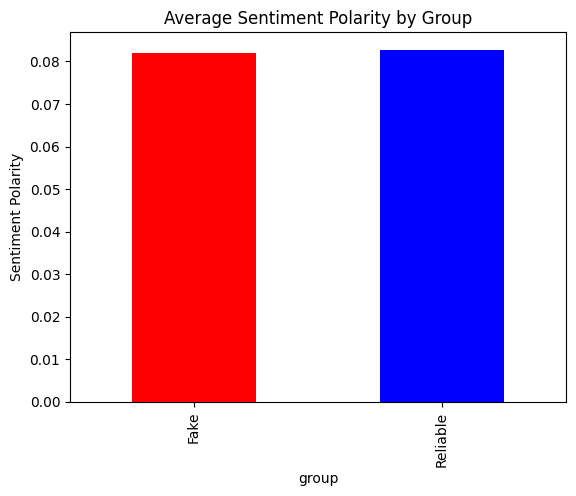

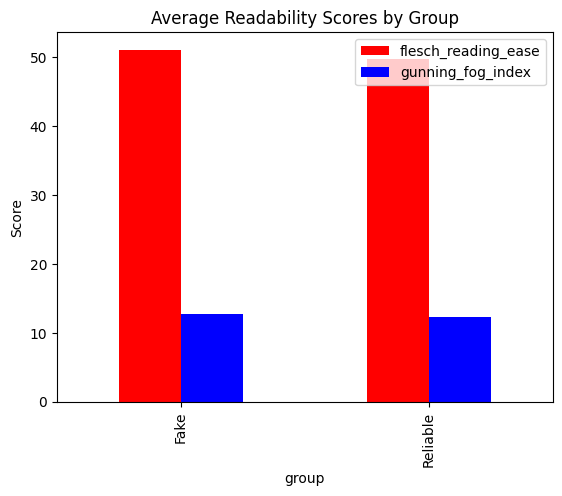

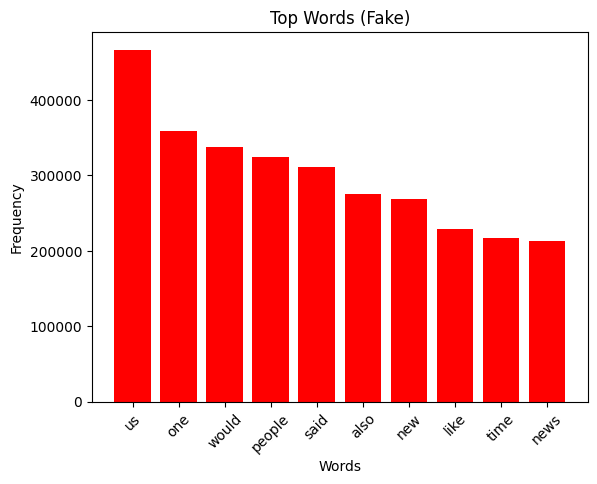

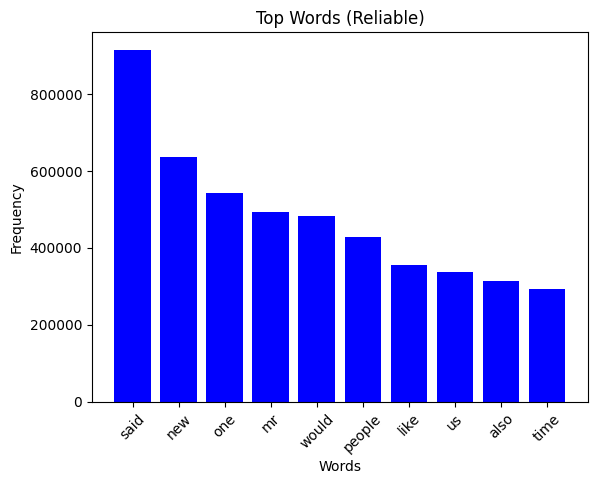

In [2]:
# Main_Part1_Task3.py
# Pasted from the original file: Main_Part1_Task3.ipynb

import pandas as pd
from cleantext import clean
import re
from textblob import TextBlob
import textstat
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import os


df = pd.read_csv("../Data/995,000_rows.csv")

# Irrelevant columns 
df.drop(['url', 'scraped_at', 'inserted_at', 'updated_at', 'title', 'authors', 'keywords', 'meta_keywords', 'meta_description', 'tags', 'summary'], axis=1, inplace=True)




def clean_text(text):
    if pd.isna(text):  # No NaN values
        return ""
    
    # Regex: Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+|[\w\.-]+\.(com|net|org|io)\S*', '', text, flags=re.MULTILINE)
    
    def clean_non_sentence_phrases(text):
        # Regex: Remove punctuation from non-sentence phrases (fx. within brackets)
        text = re.sub(r'\[([^]]+)\]', lambda match: '[' + re.sub(r'[^\w\s-]', '', match.group(1)) + ']', text)
        # Regex: Remove lonely dates or non-sentence phrases
        text = re.sub(r'\b(\d{1,2}[\/-]\d{1,2}[\/-]\d{2,4}|\w+ \d{1,2}, \d{4})\b', '', text)
        return text
    
    text = clean_non_sentence_phrases(text)
    
    cleaned_text = clean(
        text,
        fix_unicode=True,        
        to_ascii=True,           
        lower=True,              
        no_line_breaks=True,    
        no_urls=True,            
        no_emails=True,         
        no_phone_numbers=True,  
        no_numbers=True,       
        no_digits=True,         
        no_currency_symbols=True, 
        no_punct=False,          # Keep punctuation
        replace_with_punct="",   
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"               
    )
    
    
    # No extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

df['cleaned_content'] = df['content'].apply(clean_text)


##################


def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return sentiment.polarity, sentiment.subjectivity

df['sentiment'] = df['cleaned_content'].apply(analyze_sentiment)

# Tuple split for separate display
df['sentiment_polarity'] = df['sentiment'].apply(lambda x: x[0])
df['sentiment_subjectivity'] = df['sentiment'].apply(lambda x: x[1])


##################


def calculate_readability(text):
    flesch_score = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    return flesch_score, gunning_fog

df['readability'] = df['cleaned_content'].apply(calculate_readability)

df['flesch_reading_ease'] = df['readability'].apply(lambda x: x[0])
df['gunning_fog_index'] = df['readability'].apply(lambda x: x[1])



##################


# NOTE: If first time running do: 
# nltk.download('stopwords')

def get_top_words(texts, top_n=10):

    combined_text = ' '.join(texts)
    
    # Remove punctuation
    combined_text = combined_text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    words = combined_text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    

    word_freq = Counter(filtered_words)
    return word_freq.most_common(top_n)

df['top_words'] = df['cleaned_content'].apply(get_top_words)

df.drop(['content', 'sentiment', 'readability'], axis=1, inplace=True)


#### Grouping & Visualizations ####
output_folder = 'GDS_Output'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)



type_mapping = {
    'fake': 'Fake',
    'conspiracy': 'Fake',
    'political': 'Reliable',
    'unreliable': 'Fake',
    'bias': 'Fake',
    'junksci': 'Fake',
    'clickbait': 'Reliable',
    'reliable': 'Reliable',
    'hate': 'Fake'
}

# Filter out irrelevant types and map the rest
df = df[df['type'].isin(type_mapping.keys())]
df['group'] = df['type'].map(type_mapping)  # 'group' with mapped values

df.drop(columns=['type'], inplace=True)

# Check 
print(df['group'].value_counts())

avg_sentiment = df.groupby('group')[['sentiment_polarity', 'sentiment_subjectivity']].mean()
avg_readability = df.groupby('group')[['flesch_reading_ease', 'gunning_fog_index']].mean()
top_words_fake = get_top_words(df[df['group'] == 'Fake']['cleaned_content'])
top_words_reliable = get_top_words(df[df['group'] == 'Reliable']['cleaned_content'])

# Step 3: Visualize results
avg_sentiment['sentiment_polarity'].plot(kind='bar', color=['red', 'blue'])
plt.title('Average Sentiment Polarity by Group')
plt.ylabel('Sentiment Polarity')
plt.savefig(os.path.join(output_folder, 'sentiment_polarity.png'))
plt.show()

avg_readability.plot(kind='bar', color=['red', 'blue'])
plt.title('Average Readability Scores by Group')
plt.ylabel('Score')
plt.savefig(os.path.join(output_folder, 'readability_scores.png'))
plt.show()


words_fake, counts_fake = zip(*top_words_fake)
plt.bar(words_fake, counts_fake, color='red')
plt.title('Top Words (Fake)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_folder, 'top_words_fake.png'))
plt.show()

words_reliable, counts_reliable = zip(*top_words_reliable)
plt.bar(words_reliable, counts_reliable, color='blue')
plt.title('Top Words (Reliable)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_folder, 'top_words_reliable.png'))
plt.show()


# Save to CSV
df.to_csv(os.path.join(output_folder, 'analyzed_fake_news.csv'), index=False)